In [41]:
## imports
import numpy as np
import pandas as pd
import pycwt as cwt
import scipy
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta, datetime
from utils import (nearest, butter_bandpass_filter, nearesttime,
                   nearestvalue, drop, lead_sz, circ_add, circ_uniformity, rayleigh)

In [62]:
## open data
diary_events = pd.read_csv("sample_data/diary_seizures.csv")
heart_rate = pd.read_pickle("sample_data/heart_rate.pickle")
print(diary_events.head())
print(heart_rate.head())

# convert timestamps to datetime
diary_events['start_time'] = diary_events.start_time.astype("datetime64[ms]") # utc
heart_rate['timestamp'] = heart_rate.timestamp.astype("datetime64[ms]") # utc

diary_events = diary_events[diary_events['start_time'] <= datetime(2021, 1, 1)]
heart_rate = heart_rate[heart_rate['timestamp'] <= datetime(2021, 1, 1)]

print(diary_events.head())
print(heart_rate.head())
print(heart_rate['timestamp'].iloc[0], heart_rate['timestamp'].iloc[-1])

   Unnamed: 0    start_time  duration awareness motion   size
0           0  1.567230e+12      5000     Aware    NaN  Small
1           1  1.567271e+12      5000     Aware    NaN  Small
2           2  1.567332e+12      5000     Aware    NaN  Small
3           3  1.567674e+12     30000       NaN    NaN    NaN
4           4  1.567831e+12      5000     Aware    NaN  Small
      timestamp  value
0  1.570849e+12   70.0
1  1.570849e+12   73.0
2  1.570849e+12   78.0
3  1.570849e+12   75.0
4  1.570849e+12   74.0
   Unnamed: 0              start_time  duration awareness motion   size
0           0 2019-08-31 05:42:42.769      5000     Aware    NaN  Small
1           1 2019-08-31 17:00:56.662      5000     Aware    NaN  Small
2           2 2019-09-01 10:00:17.966      5000     Aware    NaN  Small
3           3 2019-09-05 09:00:00.523     30000       NaN    NaN    NaN
4           4 2019-09-07 04:30:31.081      5000     Aware    NaN  Small
            timestamp  value
0 2019-10-12 03:02:49   70.0


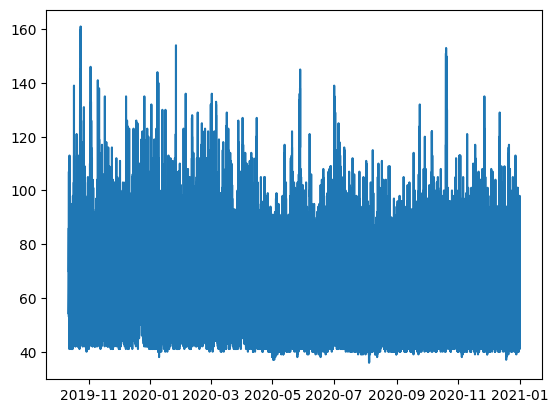

In [44]:
plt.plot(heart_rate['timestamp'][heart_rate['timestamp'] <= datetime(2021, 1, 1)], heart_rate['value'][heart_rate['timestamp'] <= datetime(2021, 1, 1)])
plt.show()

In [45]:
# variables                
WAVELET = cwt.Morlet(6)
ORDER = 2
FS=60

In [63]:
# prepare data for wavelet analysis
heart_rate = heart_rate.resample('1Min', on='timestamp').mean().reset_index()
# heart_rate['value'] = (heart_rate['value'] - heart_rate['value'].mean())/heart_rate['value'].std() #standardization
heart_rate['value'][pd.isnull(heart_rate['value'])] = heart_rate['value'].mean() # interpolation

# custom frequencies with maximum scale n (where n is 1/4 the length of the data) - i.e. we need to observe 4 cycles
n = (heart_rate['timestamp'].iloc[-1] - heart_rate['timestamp'].iloc[0]).total_seconds()/3600/4
periods = np.append(np.arange(2.4, 31.2, 1.2), np.arange(31.2, 48, 2.4))
periods = np.append(periods, np.arange(2.2*24, 4*24 + 4.8, 4.8))
periods = np.append(periods, np.arange(5*24, int(n), 12))
freqs = (1/periods)

# print(freqs)

# wavelet signal
y = heart_rate.resample('5Min', on='timestamp').mean().reset_index().value.to_numpy()

/var/folders/32/fw5qd6c92fd3qjj852lnn9tw0000gn/T/ipykernel_24522/3387645272.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  heart_rate['value'][pd.isnull(heart_rate['value'])] = heart_rate['value'].mean() # interpolation
/var/folders/32/

In [64]:
# wavelet analysis
dt = 1/12
alpha, _, _ = cwt.ar1(y) # lag 1 autocorrelation for significance (alpha = np.corrcoef(y[:-1], y[1:])[0, 1])
wave, scales, freqs, coi, fft, fftfreqs = cwt.cwt(signal = y, dt = dt, wavelet = WAVELET, freqs = freqs)
power = np.abs(wave) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs
glbl_power = power.mean(axis=1)
dof = y.size - scales  # Correction for padding at edges
var = y.std()**2
glbl_signif, tmp = cwt.significance(var, dt, scales, 1, alpha, significance_level=0.99, dof=dof, wavelet=WAVELET)
signif, fft_theor = cwt.significance(1.0, dt, scales, 0, alpha, significance_level=0.99, wavelet=WAVELET)

In [65]:
# peak analysis
# Find peaks that are significant
xpeaks = []; powers = []
ind_peaks = scipy.signal.find_peaks(var * glbl_power)[0]
for i in ind_peaks:
    peak = [var * glbl_power > glbl_signif][0][i]
    if peak:
        if period[i] not in xpeaks:
            xpeaks.append(period[i])
            powers.append([var * glbl_power][0][i])

# keep only stongest peak if there is a peak within +/- 33% of another peak
xpeaks = np.array(xpeaks)  
new_xpeaks = {}
for peak in xpeaks:
    ints2 = np.where(np.logical_and(xpeaks>=peak-0.33*peak, xpeaks<=peak+0.33*peak))
    # is the peak in another peaks BP filter?
    other = [i for i,p in enumerate(xpeaks) if peak >= p - 0.33*p and peak <= p + 0.33*p]
    ints2 = set(np.array(list(ints2[0]) + other))
    if len(ints2):
        # if there is a peak within +/- 33%, check the power of it, choose highest
        max_peak = xpeaks[[var * glbl_power][0].tolist().index(np.max([[var * glbl_power][0][i] for i in ints2]))]
        new_xpeaks[peak] = max_peak
xpeaks = sorted(set(new_xpeaks.values()))

print([x/24 for x in xpeaks])

[0.49999999999999994, 0.9999999999999997, 5.5, 9.5, 30.5, 51.5]


In [66]:
# store wavelet data
wavelet_data = pd.DataFrame()
wavelet_data['period'] = period
wavelet_data['power'] = var * glbl_power
wavelet_data['sig'] = glbl_signif
wavelet_data['peak'] = np.zeros(len(wavelet_data))
for peak in xpeaks:
    wavelet_data['peak'][wavelet_data.period == nearest(wavelet_data.period, peak)] = 1

print(wavelet_data.head())

   period         power          sig  peak
0     2.4  18047.039067   400.744080   0.0
1     3.6  33947.854062   802.346276   0.0
2     4.8  51923.333214  1234.516732   0.0
3     6.0  75790.860729  1644.119791   0.0
4     7.2  93769.565604  2006.251027   0.0


/var/folders/32/fw5qd6c92fd3qjj852lnn9tw0000gn/T/ipykernel_24522/1908787636.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  wavelet_data['peak'][wavelet_data.period == nearest(wavelet_data.period, peak)] = 1
/var/folders/32/fw5qd6c92fd3q

In [67]:
# heart rate cycle types
heart_rate_cycles = {}
for f in xpeaks:
    if round(f) == 24:
        peak_type = 'circadian'
    elif f >=(5*24) and f <=(9*24):
        peak_type = 'weekly'
    elif f >=(28*24) and f <=(32*24):
        peak_type = 'monthly'
    else:
        if f<16:
            peak_type = 'ultradian'
        else:
            peak_type = 'multiday'
    heart_rate_cycles[f] = peak_type

print(heart_rate_cycles)

{11.999999999999998: 'ultradian', 23.999999999999993: 'circadian', 132.0: 'weekly', 228.0: 'multiday', 732.0: 'monthly', 1236.0: 'multiday'}


In [68]:
# if patient has more than 20 seizures, do seizure analysis
if len(diary_events) >= 20:

    filtered = pd.DataFrame()
    filtered['timestamp'] = heart_rate['timestamp']

    for f in xpeaks:
        lowcut = 1/(f + (1/3)*f)
        highcut = 1/(f - (1/3)*f)

        # Create a new dataframe to store the filtered data around that frequency, and then corresponding phases and seizures
        filtered_data = butter_bandpass_filter(heart_rate['value'], lowcut, highcut, FS, order=ORDER)
        hilb_phases = np.angle(scipy.signal.hilbert(filtered_data)) + np.pi
        analytic_signal = scipy.signal.hilbert(filtered_data)
        amplitude_envelope = np.real(analytic_signal)
        filtered[str(f) + '_value'] = filtered_data
        filtered[str(f) + '_phase'] = hilb_phases
        filtered[str(f) + '_amp'] = amplitude_envelope

    filtered = filtered.resample('1H', on='timestamp', label='right').mean().reset_index()
    filtered['seizure'] = np.zeros(len(filtered))
    for sz in diary_events['start_time'].to_list():
        time = nearesttime(filtered.timestamp.to_list(), sz)
        filtered['seizure'][filtered.timestamp == time] += 1

/var/folders/32/fw5qd6c92fd3qjj852lnn9tw0000gn/T/ipykernel_24522/3573782196.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  filtered = filtered.resample('1H', on='timestamp', label='right').mean().reset_index()
/var/folders/32/fw5qd6c92fd3qjj852lnn9tw0000gn/T/ipykernel_24522/3573782196.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the 

In [69]:
# PLOT CONSTANTS
graph_size = (4,1.8)
hist_size = (1.6,1.6)
font_size_tick = 8
marker_sz = 3.5
hr_buffer = 0.1
ax_lw = 0.25
plot_lw = 0.5

# Prepare data and apply moving averages
slow = heart_rate.resample('1H', label = 'right', on = 'timestamp').mean().reset_index()
monthly = slow.copy()
heart_rate['MA'] = heart_rate['value'].rolling(60, min_periods = 5).mean()
slow['value'] = slow['value'].rolling(48, min_periods = 16).mean()
monthly['value'] = monthly['value'].rolling(7*24, min_periods = 5*24).mean()

# Add seizures to fast, slow and monthly dataframes
heart_rate['seizure'] = np.zeros(len(heart_rate))
slow['seizure'] = np.zeros(len(slow))
monthly['seizure'] = np.zeros(len(monthly))
for i in diary_events['start_time']:
    date, _ = nearestvalue(heart_rate, i)
    heart_rate['seizure'][heart_rate.timestamp == date] = 1
    date, _ = nearestvalue(slow, i, sec=60*60)
    slow['seizure'][slow.timestamp == date] = 1
    monthly['seizure'][monthly.timestamp == date] = 1

# find first and last time of fornightly fast plot
first_time = (heart_rate['timestamp'].iloc[-1] - heart_rate['timestamp'].iloc[0])/2 + heart_rate['timestamp'].iloc[0]
last_time = first_time + timedelta(days=14)
while drop(heart_rate, first_time, last_time).isnull().value.any():
    first_time += timedelta(days=1)
    last_time += timedelta(days=1)

# find seizure x (time) and y (hr) values for fast, slow and monthly plots
slow_sz_x = [slow['timestamp'].iloc[i] for i in slow[slow['seizure'] == 1].index]
slow_sz_y = [slow['value'].iloc[i] for i in slow[slow['seizure'] == 1].index]
monthly_sz_x = [monthly['timestamp'].iloc[i] for i in monthly[monthly['seizure'] == 1].index]
monthly_sz_y = [monthly['value'].iloc[i] for i in monthly[monthly['seizure'] == 1].index]
fast_sz_x = [i for i in drop(heart_rate, first_time, last_time)[drop(heart_rate, first_time, last_time)['seizure'] == 1].timestamp]
fast_sz_y = [i for i in drop(heart_rate, first_time, last_time)[drop(heart_rate, first_time, last_time)['seizure'] == 1].MA]

/var/folders/32/fw5qd6c92fd3qjj852lnn9tw0000gn/T/ipykernel_24522/845493636.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  slow = heart_rate.resample('1H', label = 'right', on = 'timestamp').mean().reset_index()
/var/folders/32/fw5qd6c92fd3qjj852lnn9tw0000gn/T/ipykernel_24522/845493636.py:23: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the 

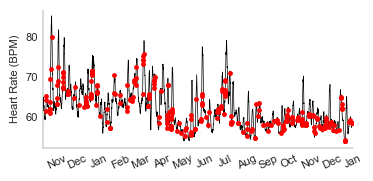

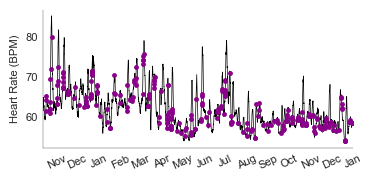

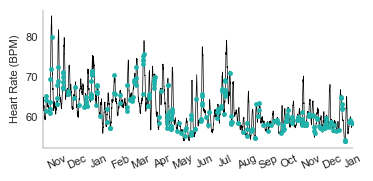

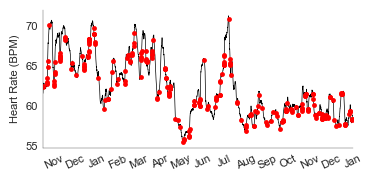

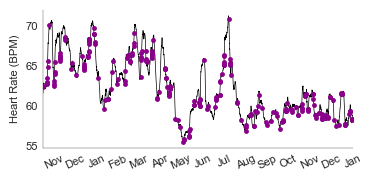

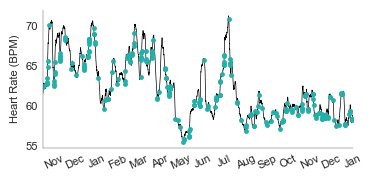

In [70]:
'''START PLOTTING'''
for dataset, sfilter, szdatax, szdatay in zip([slow, monthly], ['2-day', '7-day'], [slow_sz_x, monthly_sz_x], [slow_sz_y, monthly_sz_y]):
    for colour in ['red', 'darkmagenta', 'lightseagreen']:
        
        plt.style.use("seaborn-v0_8-white")
        fig = plt.figure(figsize=graph_size)
        plt.plot(dataset['timestamp'], dataset['value'], 'black', linewidth=plot_lw, label = '{} smoothed heart rate'.format(sfilter))
        plt.plot(szdatax, szdatay, c=colour, linestyle='', marker='o', ms=marker_sz, markeredgewidth=0, label='seizures')
        plt.ylabel('Heart Rate (BPM)', fontsize=font_size_tick)
        plt.yticks(fontsize=font_size_tick)
        plt.xticks(rotation=25, fontsize=font_size_tick)
    
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.setp(ax.spines.values(), linewidth=ax_lw)
        monthyearFmt = mdates.DateFormatter('%b')
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(monthyearFmt)

        plt.xlim([dataset.dropna()['timestamp'].iloc[0],dataset.dropna()['timestamp'].iloc[-1]])
        start, end = ax.get_ylim()
        plt.savefig(f'plots/hr_{colour[:3]}_{sfilter}_tutorial.png', bbox_inches='tight', dpi=300)
        plt.show()

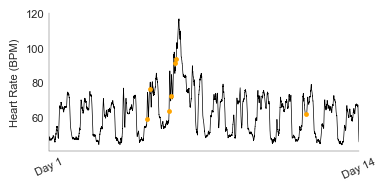

In [72]:
# plot the fast heart rate with seizures
plt.style.use("seaborn-v0_8-white")
fig = plt.figure(figsize=graph_size)
plt.plot(drop(heart_rate, first_time, last_time)['timestamp'], drop(heart_rate, first_time, last_time)['MA'], 'black',
            linewidth=plot_lw, label = '1-hour smoothed heart rate')
plt.plot(fast_sz_x, fast_sz_y, c='orange', linestyle='', marker='o', ms=marker_sz, markeredgewidth=0, label='seizures')
plt.ylabel('Heart Rate (BPM)', fontsize=font_size_tick)
plt.yticks(fontsize=font_size_tick)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.spines.values(), linewidth=ax_lw)
plt.xlim([first_time,last_time])
start, end = ax.get_ylim()
startx, endx = ax.get_xlim()
plt.xticks([startx,endx],['Day 1', 'Day 14'], rotation=25, fontsize=font_size_tick)
plt.savefig('plots/hr_inset_tutorial.png', bbox_inches='tight', dpi=300)
plt.show()

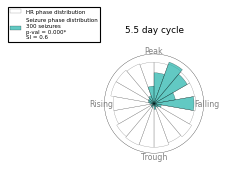

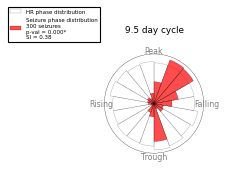

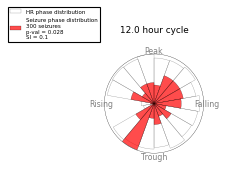

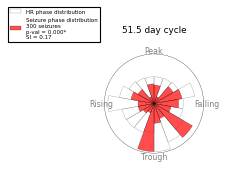

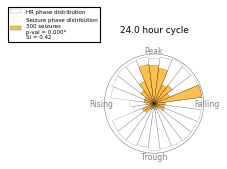

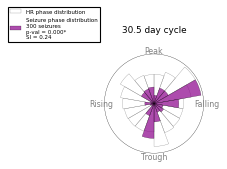

In [75]:
# gather filtered data and plot circular histograms of seizures
peaks = set([float(i[0]) for i in [i.split('_') for i in filtered.columns if i not in ['timestamp','seizure']]])
for f in peaks:

    if round(f) == 24:
        bins = 24
        peak_type = 'circadian'
        colour = 'orange'
        dayorhr = 'hour'
        freq = f
        width = (2*np.pi) / bins
    elif f >=(5*24) and f <=(9*24):
        bins = 18
        peak_type = 'weekly'
        colour = 'lightseagreen'
        dayorhr = 'day'
        freq = f/24
        width = (2*np.pi) / bins
    elif f >=(28*24) and f <=(32*24):
        bins = 18
        peak_type = 'monthly'
        colour = 'darkmagenta'
        dayorhr = 'day'
        freq = f/24
        width = (2*np.pi) / bins
    else:
        bins = 18
        colour = 'red'
        if f<16:
            dayorhr = 'hour'
            peak_type = 'ultradian'
            freq = f
        else:
            dayorhr = 'day'
            peak_type = 'multiday'
            freq = f/24
        width = (2*np.pi) / bins
        

    hist,bin_edges = np.histogram(filtered[str(f) + '_phase'], bins = bins, range=(0,np.pi*2))

    # Seizure phases
    yseizures = [filtered[str(f) + '_phase'].iloc[i] for i in filtered[filtered['seizure'] == 1].index]
    if not filtered[filtered['seizure'] > 1].empty:
        for j in range(2, int(np.max(filtered[filtered['seizure'] > 1].seizure)) + 1):
            for k in range(j):
                yseizures += [filtered[str(f) + '_phase'].iloc[i] for i in filtered[filtered['seizure'] == j].index]
    szhist, szbin_edges = np.histogram(yseizures, bins = bins, range=(0,np.pi*2))
    szhist = szhist*max(hist)/max(szhist)

    # shuffle distribution
    leads = [np.random.uniform(0,1)*2*np.pi for i in filtered[filtered['seizure'] == 1].index if lead_sz(filtered, i)[0]]
    not_leads = [circ_add(random.choice(leads),(i - lead_sz(filtered, i)[1])*2*np.pi/f) for i in filtered[filtered['seizure'] == 1].index if not lead_sz(filtered, i)[0]]
    p_random_dist = circ_uniformity(np.array(leads + not_leads))

    # get SI index
    SIphases = [np.exp(1j*ph) for ph in yseizures]
    SI=round((1/len(SIphases))*(np.abs(np.sum(SIphases))),2)
    circ_mean = scipy.stats.circmean(yseizures)

    # Check significance of non-uniformity (using Omnibus test)
    pval = circ_uniformity(np.array(yseizures))
    ray = rayleigh(np.array(yseizures))
    if pval <= 0.05/len(peaks):
        sig = '*'
    else:
        sig = ''

    # circular histogram plot:
    plt.style.use("seaborn-v0_8-white")
    plt.figure(figsize = hist_size)
    plt.style.use('classic')
    ax = plt.subplot(111, polar=True)
    ax.set_theta_direction(-1)
    ax.bar(bin_edges[:-1], hist, edgecolor='grey', fill=False, width=width, linewidth=ax_lw, label = 'HR phase distribution')
    ax.bar(szbin_edges[:-1], szhist, color=colour, fill=True, alpha=0.7, width=width, \
            linewidth=ax_lw, label='Seizure phase distribution\n{} seizures\np-val = {:.3f}{}\nSI = {}'.format(len(yseizures), pval, sig, SI))
    ax.set_xticks([np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels(['Peak', 'Falling', 'Trough', 'Rising'], fontsize = font_size_tick-1, color='grey')
    plt.legend(bbox_to_anchor = (-1,1.5), loc='upper left', fontsize=5)
    ax.set_yticks([])
    ax.tick_params(axis='both', pad=-4)
    ax.grid(False)
    ax.set_theta_zero_location("W")
    plt.setp(ax.spines.values(), linewidth=ax_lw)
    plt.title('{} {} cycle'.format(round(freq,1), dayorhr), fontsize = font_size_tick, pad = 20)
    plt.savefig(f'plots/hist_{int(f)}_tutorial.png', bbox_inches='tight', dpi=300)
    plt.show()
    

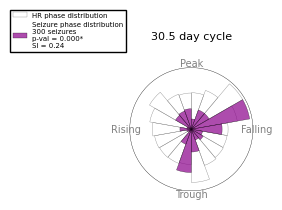